## QM9 Dataset exploration

This notebook is executed on 16, Jan, 2018. 

The tox21 dataset behavior or `chainer_chemistry` library behavior might change in the future.

Loading modules and set loglevel.

In [4]:
import logging
from chainer_chemistry import datasets

# show INFO level log from chainer chemistry
logging.basicConfig(level=logging.INFO)

QM9 dataset can be downloaded automatically by chainer chemistry. 
Original format of QM9 dataset is zipped file where each molecule's information is stored in each "xyz" file.

Chainer Chemistry automatically merge these information in one csv file internally, you may check the file path of this csv file with `get_qm9_filepath` method. 

In [3]:
dataset_filepath = datasets.get_qm9_filepath()

# print('dataset_filepath = ', dataset_filepath)

The dataset contains several chemical/physical properties, the labels of QM 9 dataset can be checked by `get_qm9_label_names` method.

In [5]:
label_names = datasets.get_qm9_label_names()
print('QM9 label_names = ', label_names)

QM9 label_names =  ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv']


More detail information is described in `readme.txt` of QM 9 dataset, which can be downloaded from 
 - [https://figshare.com/articles/Readme_file%3A_Data_description_for__Quantum_chemistry_structures_and_properties_of_134_kilo_molecules_/1057641](https://figshare.com/articles/Readme_file%3A_Data_description_for__Quantum_chemistry_structures_and_properties_of_134_kilo_molecules_/1057641)

Below is the description of each property(label), written in readme.txt

<blockquote cite="https://figshare.com/articles/Readme_file%3A_Data_description_for__Quantum_chemistry_structures_and_properties_of_134_kilo_molecules_/1057641">
<pre>
I.  Property  Unit         Description
--  --------  -----------  --------------
 1  tag       -            "gdb9"; string constant to ease extraction via grep
 2  index     -            Consecutive, 1-based integer identifier of molecule
 3  A         GHz          Rotational constant A
 4  B         GHz          Rotational constant B
 5  C         GHz          Rotational constant C
 6  mu        Debye        Dipole moment
 7  alpha     Bohr^3       Isotropic polarizability
 8  homo      Hartree      Energy of Highest occupied molecular orbital (HOMO)
 9  lumo      Hartree      Energy of Lowest occupied molecular orbital (LUMO)
10  gap       Hartree      Gap, difference between LUMO and HOMO
11  r2        Bohr^2       Electronic spatial extent
12  zpve      Hartree      Zero point vibrational energy
13  U0        Hartree      Internal energy at 0 K
14  U         Hartree      Internal energy at 298.15 K
15  H         Hartree      Enthalpy at 298.15 K
16  G         Hartree      Free energy at 298.15 K
17  Cv        cal/(mol K)  Heat capacity at 298.15 K
</pre>
</blockquote>

### Preprocessing dataset

Dataset extraction depends on the preprocessing method, which is determined by `preprocessor`.

Here, let's look an example of using `GGNNPreprocessor` preprocessor for QM9 dataset exraction.

Procedure is as follows,

1. Instantiate `preprocessor` (here `GGNNPreprocessor` is used).
2. call `get_qm9` method with `preprocessor`.

Note that `retrain_smiles` option can be used to get smiles information together with the dataset itself.

In [7]:
from chainer_chemistry.dataset.preprocessors.ggnn_preprocessor import \
    GGNNPreprocessor
    
preprocessor = GGNNPreprocessor()
dataset, dataset_smiles = datasets.get_qm9(preprocessor, labels=None, retain_smiles=True)

c:\windows\system32\pycharm\chainer-chemistry\chainer_chemistry\dataset\parsers\csv_file_parser.py:65: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  df = pandas.DataFrame.from_csv(filepath)
100%|██████████| 133885/133885 [01:19<00:00, 1680.70it/s]
INFO:chainer_chemistry.dataset.parsers.csv_file_parser:Preprocess finished. FAIL 0, SUCCESS 133885, TOTAL 133885


## Check extracted dataset

First, let's check type and number of dataset.

In [8]:
print('dataset information...')
print('dataset', type(dataset), len(dataset))

print('smiles information...')
print('dataset_smiles', type(dataset_smiles), len(dataset_smiles))

dataset information...
dataset <class 'chainer_chemistry.datasets.numpy_tuple_dataset.NumpyTupleDataset'> 133885
smiles information...
dataset_smiles <class 'list'> 133885


The dataset is a class of `NumpyTupleDataset`, where i-th dataset features can be accessed by `dataset[i]`.

When `GGNNPreprocessor` is used, each dataset consists of following features
 1. atom feature: representing atomic number of given molecule. 
 2. adjacency matrix feature: representing adjacency matrix of given molecule.
    `GGNNPreprocessor` extracts adjacency matrix of each bonding type.
 3. label feature: representing chemical properties (label) of given molecule.
    Please refer above description for details.

Let's look an example of 7777-th dataset

In [17]:
index = 7777

print('index={}, SMILES={}'.format(index, dataset_smiles[index]))
atom, adj, labels = dataset[index]
# This molecule has N=17 atoms.
print('atom', atom.shape, atom)
# adjacency matrix is NxN matrix, where N is number of atoms in the molecule.
# Unlike usual adjacency matrix, diagonal elements are filled with 1, for NFP calculation purpose.
print('adj', adj.shape)
print('adjacency matrix for SINGLE bond type\n', adj[0])
print('adjacency matrix for DOUBLE bond type\n', adj[1])
print('adjacency matrix for TRIPLE bond type\n', adj[2])
print('adjacency matrix for AROMATIC bond type\n', adj[3])

print('labels', labels)

index=7777, SMILES=CC1=NCCC(C)O1
atom (8,) [6 6 7 6 6 6 6 8]
adj (4, 8, 8)
adjacency matrix for SINGLE bond type
 [[ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  1.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.  1.  0.  0.]]
adjacency matrix for DOUBLE bond type
 [[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]
adjacency matrix for TRIPLE bond type
 [[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 

Visualizing the molecule
One might want to visualize molecule given SMILES information. Here is an example code:

In [11]:
# This script is referred from http://rdkit.blogspot.jp/2015/02/new-drawing-code.html
from __future__ import print_function
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
def moltosvg(mol,molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return svg.replace('svg:','')

smiles: CC1=NCCC(C)O1


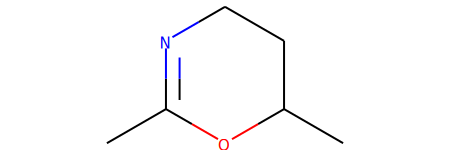

In [12]:
smiles = dataset_smiles[index]
mol = Chem.MolFromSmiles(dataset_smiles[index])

print('smiles:', smiles)
SVG(moltosvg(mol))

## Interactively watch through the QM9 dataset

Jupyter notebook provides handy module to check/visualize the data. Here interact module can be used to interactively check the internal of QM9 dataset.

index=80986, SMILES=CC12CC(=O)C(O1)C2O
atom [6 6 6 6 8 6 8 6 8]
labels [    2.851     1.527     1.218     2.477    68.23     -0.238    -0.026
     0.212  1036.831     0.135  -458.958  -458.95   -458.949  -458.99
    31.076]


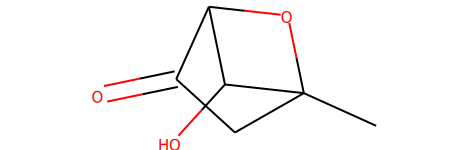

In [13]:
from ipywidgets import interact
import numpy as np
np.set_printoptions(precision=3, suppress=True)

def show_dataset(index):
    print('index={}, SMILES={}'.format(index, dataset_smiles[index]))
    atom, adj, labels = dataset[index]
    print('atom', atom)
    # print('adj', adj)
    print('labels', labels)
    mol = Chem.MolFromSmiles(dataset_smiles[index])
    return SVG(moltosvg(mol))

interact(show_dataset, index=(0, len(dataset) - 1, 1))

## Appendix: how to save the molecule figure?

`rdkit` provides `Draw.MolToFile` method to visualize mol instance and save it to png format.

In [14]:
import os
dirpath = 'images'

if not os.path.exists(dirpath):
    os.mkdir(dirpath)

In [15]:
from rdkit.Chem import Draw
index = 7777
save_filepath = os.path.join(dirpath, 'mol_{}.png'.format(index))
print('drawing {}'.format(save_filepath))

mol = Chem.MolFromSmiles(dataset_smiles[index])
Draw.MolToFile(mol, save_filepath, size=(600, 600))

drawing images\mol_7777.png
